# CITS4403 - Perth Train Network from Slime Mould

22234771 - Benjamin Longbottom

## Imports

In [59]:
import math
import numpy as np
import matplotlib.animation as ani
import matplotlib.pyplot as plt
from scipy.signal import correlate2d

### Enable matplotlib interactive plots

In [60]:
%matplotlib notebook

## Utility Functions

In [61]:
def bounded_range(minimum, lower_request, upper_request, maximum):
    """ returns a range between lower and upper request, with hard boundaries at minimum and maximum. """
    
    return range(max(minimum, lower_request), min(maximum, upper_request))
    

## Grid Class

In [62]:
class Grid:
    """
    A grid in 2 dimensional space, with a single value assigned to each cell.
    
    - Cartesian plane
    - (x, y) indexing 
    - lower left origin
    """
    
    def __init__(self, shape=(200, 100), dtype=np.float32):
        self.shape = shape
        self.width, self.height = shape
        self._im = None
        self.dtype = dtype
        
        self.grid = self.setup_grid()
    
    def setup_grid(self):
        return self.clear_grid()
    
    
    # --- Grid Operations
    
    def clear_grid(self):
        self.grid = np.zeros((self.shape), dtype=self.dtype)
        return self.grid
    
    def randomise_grid(self):
        self.grid = np.random.rand(self.height, self.width)
        return self.grid
    
        
    def add_spot(self, centre_coords, value, radius=1):
        x_centre, y_centre = centre_coords
        
        for xi in bounded_range(0, x_centre-radius, x_centre+radius+1, self.width):
            for yi in bounded_range(0, y_centre-radius, y_centre+radius+1, self.height):
                self.grid[xi, yi] = value
    
    
    # --- Cell operations
    def get_neighbour_indicies(self, cell_coords):
        """ Moore Neighbours, Returns a tuple of arrays: ( [x coords, ....], [y coords, ...] ) """
        cell_x, cell_y = cell_coords
        neighbours_x = np.array(bounded_range(0, cell_x-1, cell_x+2, self.width))
        neighbours_y = np.array(bounded_range(0, cell_y-1, cell_y+2, self.height))
            
        return (neighbours_x, neighbours_y)
    
    # --- Visualisation
    
    def draw(self, animated=False):
        """ Draws the current CA state on a 2D cartesian plane. """
        transposed_grid = self.grid.T
        if self._im is None:
            self._im = plt.imshow(transposed_grid, origin='lower', animated=animated)
        else:
            self._im.set_array(transposed_grid)
            
        return self._im
        

## Grid Types

In [63]:
class Diffusion_Grid(Grid):
    """ Diffuses values to neighbouring cells. """
    
    diffusion_kernel = np.array([[.05, .2, .05],
                                [ .2, -1, .2],
                                [.05, .2, .05]])
    
    def diffuse(self, diffusion_rate=0.5):
        diffusion_mask = correlate2d(self.grid, self.diffusion_kernel, mode='same')
        self.grid = self.grid + diffusion_rate * diffusion_mask
        return self.grid

In [64]:
class Simple_Distance_Grid(Grid):
    """ Expands outwards and stores distance from starting point. """

    dtype = np.int32
    background_value = 0

    
    def __init__(self, shape=(200, 100)):
        super().__init__(shape=shape, dtype=self.dtype)
#         self._edge_cells_set = set()
        self._edge_indicies = None
        
        
    def setup_grid(self):
        self.grid = np.full(shape=self.shape, fill_value=self.background_value, dtype=self.dtype)
        return self.grid
    
    def step(self):
        return self.step_edge_memoised()
    
#     def step_simple(self):
#         occupied_cells = list(zip(*np.where(self.grid > self.background_value)))
#         occupied_cell_set = set(occupied_cells)
        
#         for cell in occupied_cell_set:
#             neighbours_x, neighbours_y = self.get_neighbour_indicies(cell)
#             for neighbour_x in neighbours_x:
#                 for neighbour_y in neighbours_y:
#                     neighbour = (neighbour_x, neighbour_y)
#                     if (neighbour_x, neighbour_y) not in occupied_cell_set:
#                         if self.grid[neighbour] == 0 or self.grid[cell] + 1  < self.grid[neighbour]:
#                             self.grid[neighbour] = self.grid[cell] + 1
        
#         return self.grid
    
#     def step_edge_set(self):
#         if not self._edge_cells_set:
#             occupied_cells = list(zip(*np.where(self.grid > self.background_value)))
#             occupied_cell_set = set(occupied_cells)
#             self._edge_cells_set = occupied_cell_set
        
#         next_edge_set = set()
        
#         for cell in self._edge_cells_set:
#             neighbours_x, neighbours_y = self.get_neighbour_indicies(cell)
#             for neighbour_x in neighbours_x:
#                 for neighbour_y in neighbours_y:
#                     neighbour = (neighbour_x, neighbour_y)
#                     if (neighbour_x, neighbour_y) not in self._edge_cells_set:
#                         next_edge_set.add(neighbour)
#                         if self.grid[neighbour] == self.background_value or self.grid[cell] + 1 < self.grid[neighbour]:
#                             self.grid[neighbour] = self.grid[cell] + 1
        
#         self._edge_cells_set = next_edge_set
#         return self.grid
    
    def step_edge_memoised(self):
        if self._edge_indicies is None:
            self._edge_indicies = np.where(self.grid > self.background_value)
        
        next_edges_x = []
        next_edges_y = []
        
        for cell in zip(*self._edge_indicies):
            cell_x, cell_y = cell
            
            for x_dir in [-1, 0, 1]:
                for y_dir in [-1, 0, 1]:
                    # Enforce von-neumann neighbourhood
                    if abs(x_dir) == 1 and abs(y_dir) == 1:
                        continue
                    
                    neighbour_x = cell_x + x_dir
                    neighbour_y = cell_y + y_dir
                    
                    # enforce boundaries
                    if 0 > neighbour_x or neighbour_x >= self.width:
                        continue
                    if 0 > neighbour_y or neighbour_y >= self.height:
                        continue
                    
                    neighbour = (neighbour_x, neighbour_y)
                    if self.grid[neighbour] == self.background_value or self.grid[cell] + 1 < self.grid[neighbour]:
                        next_edges_x.append(neighbour_x)
                        next_edges_y.append(neighbour_y)
                        self.grid[neighbour] = self.grid[cell] + 1
        
        self._edge_indicies = (next_edges_x, next_edges_y)
        return self.grid

In [65]:
class Growing_Circle_Grid(Grid):
    """ Expands outwards and stores distance from starting point. """

    dtype = np.int32
    background_value = 0

    
    def __init__(self, shape=(200, 100)):
        super().__init__(shape=shape, dtype=self.dtype)
        self.step_count = 0
        self._edge_indicies = None
        self.centre_coords = (None, None)
        
        
    def setup_grid(self):
        self.grid = np.full(shape=self.shape, fill_value=self.background_value, dtype=self.dtype)
        return self.grid
    
    def add_spot(self, centre_coords, value, radius=1):
        self.centre_coords = centre_coords
        super().add_spot(centre_coords, value, radius=radius)
    
    def step(self):
        return self.step_edge_memoised()
    
    def step_edge_memoised(self):
        if self._edge_indicies is None:
            self._edge_indicies = np.where(self.grid > self.background_value)
        
        centre_x, centre_y = self.centre_coords
        
        next_edges_x = []
        next_edges_y = []
        
        for cell in zip(*self._edge_indicies):
            cell_x, cell_y = cell
            
            for x_dir in [-1, 0, 1]:
                for y_dir in [-1, 0, 1]:
                    neighbour_x = cell_x + x_dir
                    neighbour_y = cell_y + y_dir
                    
                    # enforce boundaries
                    if 0 > neighbour_x or neighbour_x >= self.width:
                        continue
                    if 0 > neighbour_y or neighbour_y >= self.height:
                        continue
                    
                    # skip any neighbours outside of 'circle' with radius step_count
                    neighbour_dist_from_centre = math.sqrt((centre_x - neighbour_x) ** 2 + (centre_y - neighbour_y) ** 2)
                    if neighbour_dist_from_centre > self.step_count + 1:
                        continue
                    
                    neighbour = (neighbour_x, neighbour_y)
                    if self.grid[neighbour] == self.background_value or self.grid[cell] + 1 < self.grid[neighbour]:
                        next_edges_x.append(neighbour_x)
                        next_edges_y.append(neighbour_y)
                        self.grid[neighbour] = self.grid[cell] + 1
        
        self._edge_indicies = (next_edges_x, next_edges_y)
        
        self.step_count += 1
        return self.grid

In [67]:
class True_Distance_Grid(Grid):
    """ Expands outwards and stores distance from starting point. """

    dtype = np.int32
    background_value = 0

    
    def __init__(self, shape=(200, 100)):
        super().__init__(shape=shape, dtype=self.dtype)
        self._x_grid = np.full(shape=self.shape, fill_value=self.background_value, dtype=self.dtype)
        self._y_grid = np.full(shape=self.shape, fill_value=self.background_value, dtype=self.dtype)
        self._edge_indicies = None
        
        
    def setup_grid(self):
        self.grid = np.full(shape=self.shape, fill_value=self.background_value, dtype=self.dtype)
        return self.grid
    
    def add_spot(self, centre_coords, value, radius=1):
        x_centre, y_centre = centre_coords
        
        for xi in bounded_range(0, x_centre-radius, x_centre+radius+1, self.width):
            for yi in bounded_range(0, y_centre-radius, y_centre+radius+1, self.height):
                self._x_grid[xi] = 1
                self._y_grid[yi] = 1
                self.grid[xi, yi] = 1
    
    def step(self):
        if self._edge_indicies is None: 
            self._edge_indicies = np.where(self.grid > self.background_value)
        
        next_edges_x = []
        next_edges_y = []
        
        for cell in zip(*self._edge_indicies):
            cell_x, cell_y = cell
            
            for x_dir in [-1, 0, 1]:
                for y_dir in [-1, 0, 1]:
                    neighbour_x = cell_x + x_dir
                    neighbour_y = cell_y + y_dir
                    if 0 > neighbour_x or neighbour_x >= self.width:
                        continue
                    if 0 > neighbour_y or neighbour_y >= self.height:
                        continue
                    
                    neighbour = (neighbour_x, neighbour_y)
                    if self.grid[neighbour] == self.background_value or self.grid[cell] + 1 < self.grid[neighbour]:
                        self._x_grid[neighbour] = self._x_grid[cell] + x_dir
                        self._y_grid[neighbour] = self._y_grid[cell] + y_dir
                        self.grid[neighbour] = math.sqrt(self._x_grid[neighbour] ** 2 + self._y_grid[neighbour] ** 2)
                        next_edges_x.append(neighbour_x)
                        next_edges_y.append(neighbour_y)
        
        self._edge_indicies = (next_edges_x, next_edges_y)
        return self.grid

In [68]:
class Slime_Grid(Grid):
    """ A grid of the Slime_CA. """
    def __init__(self, shape, dtype=np.int32):
        super().__init__(shape, dtype)
        self.distance_grids = dict()
        self.visualisation_grid = Grid(shape, dtype=dtype)
        
    def add_spot(self, centre_coords, value, radius=0):
#         new_dist_grid = Simple_Distance_Grid(shape=self.shape)
        new_dist_grid = Growing_Circle_Grid(shape=self.shape)
        new_dist_grid.add_spot(centre_coords, 1, 0)
        self.distance_grids[centre_coords] = new_dist_grid
        self.visualisation_grid.add_spot(centre_coords, 1, 0)
        
    def step(self):
        for distance_grid in self.distance_grids.values():
            distance_grid.step()
            self.visualisation_grid.grid[distance_grid._edge_indicies] = distance_grid.grid[distance_grid._edge_indicies]
        return self.visualisation_grid.grid

    def draw(self, animated=False):
        return self.visualisation_grid.draw(animated=animated)

## Slime Mould - Cellular Automata Model

In [69]:
class Slime_CA:
    
    def __init__(self, shape=(20, 10)):
        self.width, self.height = shape
        self.shape = shape
        self.slime_grid = Slime_Grid(shape)
    
    def add_food(self, centre_point, radius=0):
        self.slime_grid.add_spot(centre_point, 1, 0)
    
    def step(self):
        return self.slime_grid.step()
    
    def draw(self, animated=False):
        return self.slime_grid.draw(animated=animated)

## Cellular Automata Animator

In [70]:
class CA_Animator:
    
    def __init__(self, ca, fig=None):
        self.ca = ca
        if fig is None:
            fig = plt.figure()
        self.fig = fig
        self.current_frame = 0
        self.cbar = None
     
    def animate(self, frame_count=10, interval=20):
        self.frame_count = frame_count
        
        self.anim = ani.FuncAnimation(
            self.fig, 
            self._update_frame, 
            init_func=self._setup_fig, 
            frames=self.frame_count, 
            interval=interval,
            repeat=False)
        
        plt.show()
        return self.anim
    
    def _setup_fig(self, *args):
        self.im = self.ca.draw(animated=True)
        self.cbar = plt.colorbar(self.im)
        max_distance = math.sqrt(math.pow(self.ca.height, 2) + math.pow(self.ca.width, 2))
        plt.clim(0, max_distance)
        return (self.im,)
    
    def _update_frame(self, frame_index):
        new_grid = self.ca.step()
        self.im = self.ca.draw()
        if frame_index <= self.frame_count:
            self.current_frame = frame_index
            return (self.im,)


## Running the Slime Mould CA model

<IPython.core.display.Javascript object>


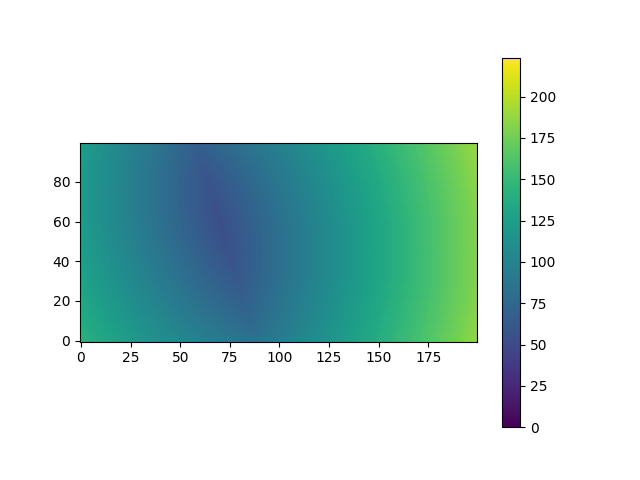

In [78]:
ca = Slime_CA(shape=(200,100))
ca.add_food((20, 45), radius=0)
ca.add_food((120, 75), radius=0)


animator = CA_Animator(ca)
animator.animate(frame_count=200, interval=0)

<IPython.core.display.Javascript object>


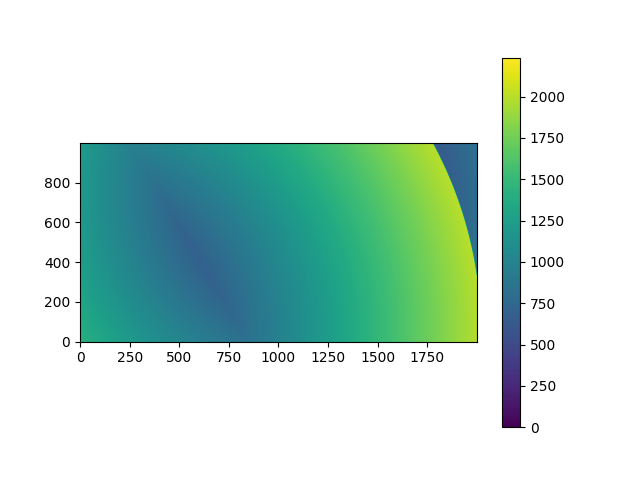

In [77]:
ca = Slime_CA(shape=(2000,1000))
ca.add_food((20, 45), radius=0)
ca.add_food((1200, 750), radius=0)


animator = CA_Animator(ca)
animator.animate(frame_count=2000, interval=0)

In [72]:
ca.slime_grid.distance_grids.values()

dict_values([<__main__.Growing_Circle_Grid object at 0x121d36c50>, <__main__.Growing_Circle_Grid object at 0x121d36d50>])

In [73]:
np.where(list(ca.slime_grid.distance_grids.values())[0] != 0)

(array([0]),)

In [74]:
list(ca.slime_grid.distance_grids.values())[0]

In [75]:
animator._setup_fig(5)

(<matplotlib.image.AxesImage at 0x121d82a90>,)

In [79]:
animator._update_frame(5)

(<matplotlib.image.AxesImage at 0x12204a650>,)